In [70]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test, ON_THRESHOLD
from sklearn.metrics import mean_absolute_error
import os
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../code/')
%matplotlib inline
import itertools
from pathlib import Path

In [71]:
params = np.load("../code/baseline/result/cnn-tree-param-1.npy").item()

In [72]:
params

{0: {'iters': 6000, 'lr': 0.01, 'order': ('dw', 'dr', 'hvac', 'fridge', 'mw')},
 1: {'iters': 20000,
  'lr': 0.01,
  'order': ('dr', 'fridge', 'mw', 'dw', 'hvac')},
 2: {'iters': 18000,
  'lr': 0.01,
  'order': ('dr', 'fridge', 'hvac', 'mw', 'dw')},
 3: {'iters': 19000,
  'lr': 0.01,
  'order': ('dw', 'fridge', 'mw', 'dr', 'hvac')},
 4: {'iters': 19000,
  'lr': 0.01,
  'order': ('fridge', 'dr', 'mw', 'dw', 'hvac')}}

In [110]:
gid = 0
c=0
k=0
dataset = 1
test_error = {}
week =2
for fold_num in range(5):
    lr = params[fold_num]['lr']
    iters = params[fold_num]['iters']
    order = params[fold_num]['order']
    iters = 20000
    p = 0.0
    test_error[fold_num] = {}
    for aug_rate in [0.2, 0.5, 1, 2, 5]:
#         aug_rate = float(aug_rate)
        test_error[fold_num][aug_rate] = {}
        for random_seed in range(3):
            k+=1
            aug_rate = float(aug_rate)
            o = "\', \'".join(str(x) for x in order)
            directory = "../code/baseline/cnn-tree-aug/method_1/{}/{}/{}/{}/{}/{}/{}/{}/".format(dataset, fold_num, lr, iters, p, week, aug_rate, random_seed)
            filename = "test-error-[\'{}\'].npy".format(o)

            full_path = directory + filename
#             print(full_path)
            my_file = Path(full_path)
            
            test_error[fold_num][aug_rate][random_seed] = np.load(full_path).item()
#             if not my_file.exists():
#                 c+=1
#                 o = " ".join(str(x) for x in params[fold_num]['order'])
#                 print("CUDA_VISIBLE_DEVIECS={} python cnn-tree-aug.py 3 {} {} {} {} {} {} {} ".format(gid, lr, iters, p, fold_num, aug_rate, random_seed, o))
#                 gid += 1
#                 if gid == 2:
#                     gid = 1

print(c, k, c/k)

0 75 0.0


In [122]:
mean_error={}
param = {}
for fold_num in range(5):
    mean_error[fold_num]={}
    param[fold_num]={}
    for aug_rate in [0.2, 0.5, 1, 2, 5]:
        mean_error[fold_num][aug_rate] = {}
        param[fold_num][aug_rate]={}
        for random_seed in range(3):
            param[fold_num][aug_rate][random_seed] = pd.DataFrame(test_error[fold_num][aug_rate][random_seed]).mean(axis=0).argmin()
            mean_error[fold_num][aug_rate][random_seed] = pd.DataFrame(test_error[fold_num][aug_rate][random_seed]).mean(axis=0).min()

/zf14/yj9xs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  # Remove the CWD from sys.path while we load stuff.


In [123]:
param

{0: {0.2: {0: 1000, 1: 1000, 2: 1000},
  0.5: {0: 1000, 1: 1000, 2: 20000},
  1: {0: 1000, 1: 1000, 2: 1000},
  2: {0: 1000, 1: 1000, 2: 1000},
  5: {0: 15000, 1: 1000, 2: 2000}},
 1: {0.2: {0: 2000, 1: 7000, 2: 17000},
  0.5: {0: 4000, 1: 18000, 2: 1000},
  1: {0: 20000, 1: 4000, 2: 3000},
  2: {0: 11000, 1: 4000, 2: 3000},
  5: {0: 6000, 1: 2000, 2: 2000}},
 2: {0.2: {0: 19000, 1: 10000, 2: 18000},
  0.5: {0: 17000, 1: 17000, 2: 11000},
  1: {0: 17000, 1: 20000, 2: 15000},
  2: {0: 20000, 1: 19000, 2: 16000},
  5: {0: 14000, 1: 17000, 2: 16000}},
 3: {0.2: {0: 20000, 1: 12000, 2: 13000},
  0.5: {0: 19000, 1: 13000, 2: 9000},
  1: {0: 20000, 1: 20000, 2: 4000},
  2: {0: 11000, 1: 19000, 2: 17000},
  5: {0: 19000, 1: 17000, 2: 18000}},
 4: {0.2: {0: 1000, 1: 12000, 2: 2000},
  0.5: {0: 13000, 1: 17000, 2: 6000},
  1: {0: 4000, 1: 5000, 2: 13000},
  2: {0: 2000, 1: 4000, 2: 12000},
  5: {0: 6000, 1: 2000, 2: 2000}}}

In [124]:
num_homes = {0:14, 1:14, 2:14, 3:13, 4:13}

In [125]:
seed = {}

for fold_num in range(5):
    seed[fold_num] = {}
    for aug_rate in [0.2, 0.5, 1, 2, 5]:
        seed[fold_num][aug_rate] = pd.Series(mean_error[fold_num][aug_rate]).argmin()
#         print(fold_num, aug_rate, pd.Series(mean_error[fold_num][aug_rate]).min())

/zf14/yj9xs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  


In [126]:
for aug_rate in [0.2, 0.5, 1, 2, 5]:
    error = 0
    for fold_num in range(5):
        error += pd.Series(mean_error[fold_num][aug_rate]).min()*num_homes[fold_num]
    print(aug_rate, error/68)

0.2 51.6843962679
0.5 50.7440464303
1 53.2346095396
2 54.8071035314
5 56.0202806889


In [127]:
result = {}
for aug_rate in [0.2, 0.5, 1, 2 ,5]:
    result[aug_rate] = {}
    for appliance in APPLIANCE_ORDER[1:-1]:
        app_error = 0
        for fold_num in range(5):

            iters = param[fold_num][aug_rate][seed[fold_num][aug_rate]]
            error = test_error[fold_num][aug_rate][seed[fold_num][aug_rate]][iters]
            app_error += error[appliance] * num_homes[fold_num]
#         print(appliance, app_error/68)
        result[aug_rate][appliance] = app_error/68

In [129]:
result[0] = {}
result[0]['hvac'] = 150.22
result[0]['fridge'] = 32.52
result[0]['dr'] = 51.18
result[0]['dw'] = 15.32
result[0]['mw'] = 8.57

In [152]:
df_mean = pd.DataFrame(result).mean()

In [153]:
df_mean[0.2] = 51.41

In [156]:
df_mean

0.0    51.562000
0.2    51.410000
0.5    50.744046
1.0    53.234610
2.0    54.807104
5.0    56.020281
dtype: float64

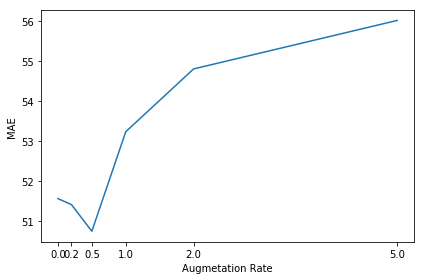

In [159]:
df_mean.plot()
plt.ylabel("MAE")
plt.xlabel("Augmetation Rate")
plt.xticks([0, 0.2, 0.5, 1, 2, 5])
plt.tight_layout()
plt.savefig("./figure/augmentation.pdf", format='pdf')
# the_table = plt.table(cellText=result)
